In [25]:
#Inspired by https://avandekleut.github.io/vae/
import torch;
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [27]:
class FF(nn.Module):
    def __init__(self,dim1,dim2,dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)
tmp = FF(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

FF(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
torch.Size([10, 1, 2])


In [28]:
class Autoencoder(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.encoder = FF(dim1, dim2, dim3)
        self.decoder = nn.Sequential(
            FF(dim3, dim2, dim1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
tmp = Autoencoder(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

Autoencoder(
  (encoder): FF(
    (main): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): Sequential(
    (0): FF(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (1): Sigmoid()
  )
)
torch.Size([10, 1, 784])


In [29]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

In [30]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0, dim1], z[:, 0, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [31]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [32]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())

loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

0/0: 0.23226046562194824
0/100: 0.061143893748521805
0/200: 0.055555008351802826
0/300: 0.051857251673936844
0/400: 0.04897250980138779
1/0: 0.05598399415612221
1/100: 0.04558886960148811
1/200: 0.04866906628012657
1/300: 0.04766656458377838
1/400: 0.049610983580350876
2/0: 0.04810959845781326
2/100: 0.04594115912914276
2/200: 0.04302823916077614
2/300: 0.04566510021686554
2/400: 0.04587947577238083
3/0: 0.04651687666773796
3/100: 0.044547490775585175
3/200: 0.04729239642620087
3/300: 0.045281197875738144
3/400: 0.04453068971633911
4/0: 0.045663025230169296
4/100: 0.04260411113500595
4/200: 0.04196753352880478
4/300: 0.04328039661049843
4/400: 0.04297981411218643
5/0: 0.04500850290060043
5/100: 0.04504311457276344
5/200: 0.04744424298405647
5/300: 0.043859582394361496
5/400: 0.04323895648121834
6/0: 0.042626749724149704
6/100: 0.041366081684827805
6/200: 0.04043303057551384
6/300: 0.04393439367413521
6/400: 0.042025916278362274
7/0: 0.041124921292066574
7/100: 0.04364138841629028
7/200

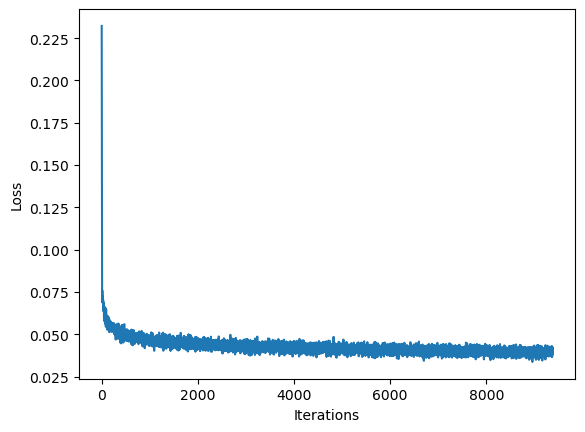

In [33]:
# Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the losses
plt.plot(losses)

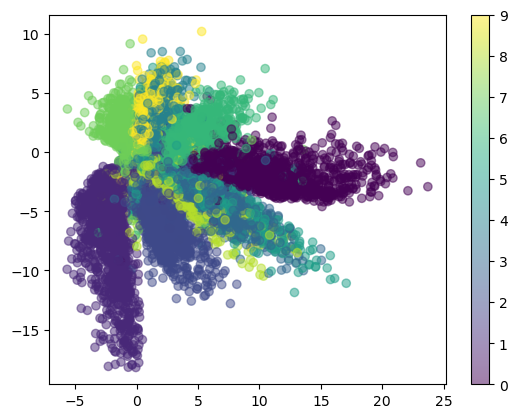

In [34]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.pdf')

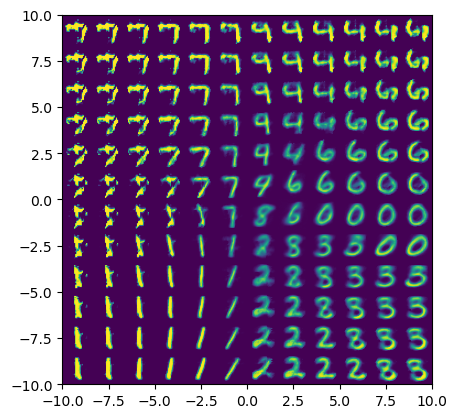

In [35]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.pdf')

#### Task 2.3

In [69]:
from sklearn.decomposition import PCA

X = data.data.reshape(len(data), -1).numpy() / 255
y = data.targets.numpy()
pca = PCA(n_components=32, random_state=0)
Z = pca.fit_transform(X)

class PCAEncoder(nn.Module):
    def __init__(self, pca_obj):
        super().__init__()
        self.register_buffer("mean", torch.from_numpy(pca_obj.mean_).float())
        self.register_buffer("components", torch.from_numpy(pca_obj.components_).float())

    def forward(self, x):
        x_flat = x.view(x.size(0), -1).cpu().float()
        z = torch.matmul(x_flat - self.mean, self.components.t())
        return z.view(x.size(0), 1, -1)

class PCADecoder(nn.Module):
    def __init__(self, pca_obj):
        super().__init__()
        self.register_buffer("mean", torch.from_numpy(pca_obj.mean_).float())
        self.register_buffer("components", torch.from_numpy(pca_obj.components_).float())

    def forward(self, z):
        z_flat = z.view(z.size(0), -1).cpu().float()
        x_hat = torch.matmul(z_flat, self.components) + self.mean
        return x_hat.view(z.size(0), 1, -1).to(z.device)

pca_encoder = PCAEncoder(pca).to(device)
pca_decoder = PCADecoder(pca).to(device)


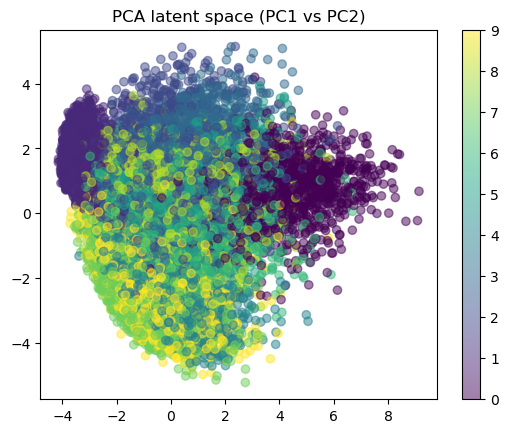

In [70]:
plt.figure()
plot_latent(data_loader, pca_encoder, dim1=0, dim2=1, num_batches=100)
plt.title("PCA latent space (PC1 vs PC2)")
plt.savefig("pca_latent_space.pdf")